# Keras nuts-and-bolts

I've been trying some new architectures, but I want to be able to do some sanity checks that I'm doing what I want to do for these newer models.

1. I should be reweighting the track loss by the number of tracks so that I'm not giving more emphasis to jets with more tracks
2. I just also kind of wanted to make sure that the masking was working for architectures with multiple outputs


In [1]:
import numpy as np
import h5py
import sys
import os
import pandas as pd
import xarray as xr

# Visulalizations
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Functions from other modules that I've written
sys.path.append("..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### Step 1: Load in the data

In [10]:
dataFile = '../data/mc16d'
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTag = "3m_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}_4trkClasses.hdf5".format(dataFile,dataTag)

In [11]:
f = h5py.File(f_name,"r")
    
X_te = f['X_test'][:]
y_te = f['y_test'][:]
y_trk_te = f['y_trk_test'][:].astype(int)
ix_te = f['ix_test'][:]

f.close()

### Step 2: Load in the model

Plan: Load in a model that I trained w/ 4 classes + this corrected loss!

In [12]:
nFeatures=13
timeSteps=15
modelDir='../models/mc16d/'
modelName = "LSTM_4_trkClass_50units_10dense_15trkDense_3m_15trks_{}_sd0_rev_alpha1.0".format(vStr)

In [13]:
# Ok, let's load in the model + the weights in separately
m = LSTM_trkClass(modelDir=modelDir, timeSteps=timeSteps, modelName=modelName,
                  nFeatures=nFeatures, loadModel=True, doEmbedding=False, 
                  nTrkClasses=4, nDenseTrk=15)

Initialize method from myModel()
alpha= 0.5
Loading weights for previously trained model


Jet_class_acc
Jet_class_loss
Trk_class_acc
Trk_class_loss
loss
val_Jet_class_acc
val_Jet_class_loss
val_Trk_class_acc
val_Trk_class_loss
val_loss


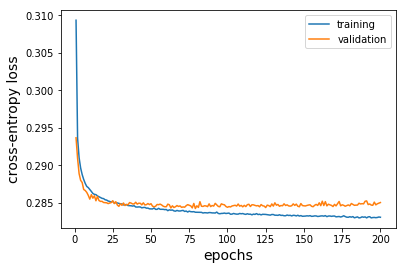

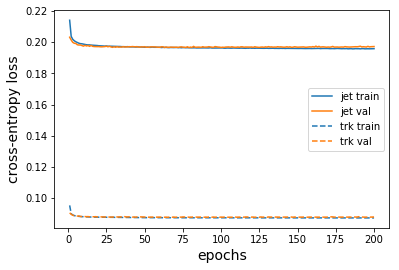

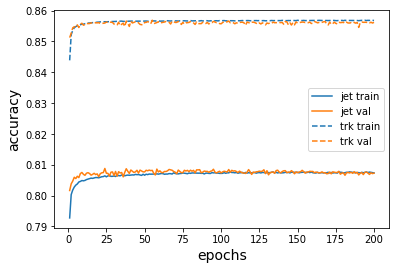

In [14]:
trainingMetrics(m.modelName)

**Notes:**
- The early stopping criterion is *never met*
- The loss is much lower than before
- It doesn't seem like the jet accuracy is much better
- Track classification is *easier*, i.e, the track loss is lower and the track accuracy is higher
    - I'll be interested to see how the other models with lower $\alpha$ fare
- This model is clearly overfitting, 
    - The validation loss plateaus after epoch 30, but the training loss keeps going down w/o generalizing to the validation set. 
    - I'll be interested to see how the model *without* the extra TimeDistributedDense layer for track classification does, because this will mean fewer track parameters.
- I could also try training w/ more data?


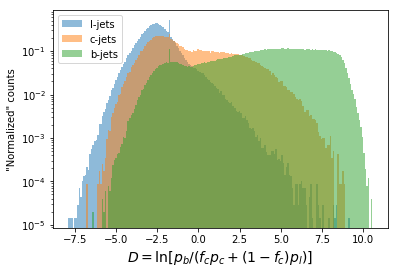

In [29]:
leffs, ceffs, beffs = [], [], []

leff, ceff, beff = sigBkgEff(m,X_te,y_te,ix_te)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

In [30]:
labels = ['test']

../plottingFcts.py:428: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


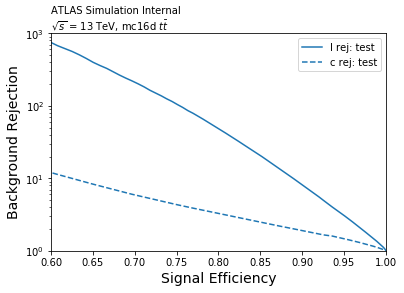

In [31]:
btagROC(beffs, leffs, ceffs, labels)#, tag='15de_4Classes',subDir='mc16d')

The problems with overfitting indicate that this model is actually doing as bad as if we only trained with $L_{jet}$.

In [33]:
%%bash
ls ../data/mc16d/*pPerp*

../data/mc16d/data_1k_15trks_sd0_sz0_ip3d_d0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_prbP_pPerp_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_4trkClasses.hdf5
../data/mc16d/data_3m_15trks_sd0_sz0_ip3d_d0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_prbP_pPerp_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_4trkClasses.hdf5
../data/mc16d/scale_1k_15trks_sd0_sz0_ip3d_d0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_prbP_pPerp_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
../data/mc16d/scale_3m_15trks_sd0_sz0_ip3d_d0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_prbP_pPerp_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
